In [1]:
# Defining the working environment, getting libraries and modules.
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

    Maze Environment: In the contex of reinformcement learning is a simulated setting where an agent go around a grid of path and obsacles to reach specific goals. 

In [2]:
# Defining the Rules "of the game"
HIT_OBSTACLE = -15  #The robot receives a penalty of -15 for hittting an obstacle
FAST_DELIVERY = +100    # The robot receives a reward of +30 for reachinga goal quicly
SLOW_DELIVERY = +50    # The robot receives a reward of + 10 for reaching a goal at a slower pace
MOVE_PENALTY = -1    # Each move has -1 penalty to avoid excesive movement
FAST_DELIVERY_LIMIT = 40    # Threshold definition to define the limit between fast/slow delivery

class MazeEnv:    # Maze environment
    def __init__(self, grid_size=10, authorized_paths=None, goals=None): # grid_size This part defines the size of the grid, in this case 10x10
        self.grid_size = grid_size    
        self.authorized_paths = set(authorized_paths) if authorized_paths else set()    # The authorized_paths is a set of coordinates where the robot is allowed to move. If any is provided, it defaults to empty, meaning that the robot doesn't move
        self.goals = goals if goals else [(9, 2), (9, 6)]    # Cells that the agent should reach
        self.reset()

    def reset(self):    # Provide instructions for resseting a new "try", a new episode, this new episode is called for two reasons: 1) previous failure or 2) fresh call () 
        # Start at random authorized path
        self.robot_position = random.choice(list(self.authorized_paths))
        return self.robot_position

    def is_goal(self, position):
        return position in self.goals

    def move(self, action):
        movements = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }

        new_position = (self.robot_position[0] + movements[action][0],     # New position update: calculate the new position based on the current position and the action. I f the new position is valid, it updates the robot position.
                        self.robot_position[1] + movements[action][1])

        if (new_position in self.authorized_paths and
            0 <= new_position[0] < self.grid_size and
            0 <= new_position[1] < self.grid_size):
            self.robot_position = new_position
            return new_position, MOVE_PENALTY, self.is_goal(self.robot_position)
        else:
            return self.robot_position, HIT_OBSTACLE, False     # This part only executes when the attempted move is not valid. In that case the return is: a) Robot remains in the same place, b) penalty, c) False, that is returned to inform when a goal wans't reached in the last move. 

    def get_possible_actions(self):
        return ['up', 'down', 'left', 'right']

    def get_obstacles(self):
        """Automatically identify obstacles (anything not authorized, goal, or starting point)"""
        all_positions = {(i, j) for i in range(self.grid_size) for j in range(self.grid_size)}
        return all_positions - self.authorized_paths - set(self.goals)


    Differences between the previous and the next function:
    
        First, both of them teach the agent, however they do it in a slightly different way. The previous one is like the definition of the game, with rules, the field... The second one is like playing the game.
        
        a) The previous code set the environment and rules.
        b) The next code is used to learn based on the previous code. 

# Points to consider for the code below:
        Regarding the fast delivery limit: By providing more time under the umbrella of a higher reward, the agent can afford to explore strategies that might take slightly longer but could lead to more consistent or higher overall rewards. 

#### Next, Two combination showing 2 opposite results. The best/the worst.

    BEST SCENARIO:
    fast_delivery_limit: higher value.
    fast_delivery: very high reward.
    slow_delivery: moderately low reward.

    ==> Pushes the agent to perform efficiently but doesn't penalize for slow exploration too much. Not appropiate for complex environments.

------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------

    WORST SCENARIO:
    fast_delivery_limit: low value.
    fast_delivery: low reward.
    slow_delivery: same or higher than fast_delivery. 

    ==> This configuration might confuse the agent's priorities as it removes the urgency and clear reward hirearchy that helps to optimize the behaviour.

# Q-learning Process:
## 1.- Initialization:
    a) q_table: A table to store Q-values, initialized with zeros for all state-action pairs.
    b) steps_vs_iters: List to record the number of steps taken in each episode.

## 2.- Loop Over Episodes:
    For each episode, the environment is reset, and variables for tracking steps and rewards are initialized.
    
    ** Remember than an episode is "each time than the agent plays the game until dies"

## 3.- Epsilon-Greedy Policy:
    The agent decides whether to take a random action (exploration) or the best known action (exploitation) based on the epsilon value.
    
    Epsilon decays over time, reducing random actions and increasing reliance on learned Q-values. 
    
    Q-Values, represent the quality of a certain action taken in a given state. It guides to the agent to choose actions that maximize th ecumulative reward over time.

## 4.- Action Execution and Environment Interaction:
The agent performs an action, and the environment responds with the next state, a reward, and a flag indicating if a goal was reached (done).

## 5.- Reward Adjustment:
If a goal is reached ("done" is "True"), additional rewards are given based on whether it was a fast or slow delivery.

## 6.- Q-value Update (Q-Learning Formula):
The Q-value for the current state and action is updated using the Q-learning formula:

    Q(state, action) = (1−α) * Q(state, action) + α * (reward + γ * maxQ * (next state))
    
This formula combines the old Q-value with the learned value (reward received plus the discounted maximum Q-value of the next state).

## 7.- State Update:
The state is updated to the next state. Steps are incremented, rewards are increased/decreased.

## 8.- Data Collection:
Steps taken in the episode are recorded.

## 9.- Decay of Parameters:
Epsilon and alpha are decayed to gradually shift from exploration to exploitation and to stabilize learning as the agent becomes more experienced.

## Return Values:
### q_table: The final table of learned Q-values.
### steps_vs_iters: A record of how many steps were needed in each episode.

In [3]:
def qlearn(env,     # The environment in which the agent operates
           num_iters,    # Number of episodes or trials the learning process should run.
           alpha,     # Learning rate, determines how much the new inf. affects the existing knowledge sotred. High lr affects a lot, lower lr affect little ("The trade off between taking the new information at a cost of forgeting the new one")
           gamma,    # Discount factor, indicates how important are inmediate rewards in comparison to future rewards. 1.0 = for strategies close to long-term gains. close to 0 = agent prioritize the immediate rewards.
           epsilon,    # Chance of taking a random action, exploration rate. helps to decide whether to take an unknown action or the best known action. 
           max_steps,    # Max number of steps the agent can take in a single episode or a sinle game.
           fast_delivery_limit,    # if the agent reach a goal within this limit, it receives a larger reward. giving lager limits promotes efficiency in the long run because the agent has more time to explore and find better way.
           fast_delivery,     
           slow_delivery, 
           epsilon_decay=0.99, # epsilon decay, reduce the epsilon over time. As the agent learns, it needs less exploration at the time uses more the explotaition of its knowledge.
           alpha_decay=0.99):    # alpha decay, reduce the alpha over time. as the agent knows the environment, the impact of new information is smaller over the already known information. 
    
    q_table = defaultdict(lambda: defaultdict(float))
    steps_vs_iters = []    # This is a list to store the number of steps taken in each episode
    rewards_vs_iters = []

    for episode in range(num_iters):
        state = env.reset()
        total_steps = 0
        total_reward = 0
        done = False

        while not done and total_steps < max_steps:
            # Epsilon-greedy policy with decay
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.get_possible_actions())
            else:
                action = max(q_table[state], 
                             key=q_table[state].get,
                             default=random.choice(env.get_possible_actions()))

            # Execute action and receive reward
            next_state, reward, done = env.move(action)

            # Determine additional reward based on fast or slow delivery
            if done:
                if total_steps <= fast_delivery_limit:
                    reward += fast_delivery
                else:
                    reward += slow_delivery

            # Q-Learning update
            next_max = max(q_table[next_state].values(), default=0)
            old_q_value = q_table[state][action]
            new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
            q_table[state][action] = new_q_value

            # Update state
            state = next_state
            total_steps += 1
            total_reward += reward

        # Append the total steps taken and reward received for each episode
        steps_vs_iters.append(total_steps)
        rewards_vs_iters.append(total_reward)

        # Decay exploration and learning rate
        epsilon *= epsilon_decay
        alpha *= alpha_decay

    return q_table, steps_vs_iters, rewards_vs_iters

def plot_maze(env, start_position):
    """Visualize the Maze Environment with enhanced colors and symbols"""
    maze = np.full((env.grid_size, env.grid_size), ' ')
    for cell in env.authorized_paths:
        maze[cell[0], cell[1]] = 'A'  # Authorized paths
    for goal in env.goals:
        maze[goal[0], goal[1]] = 'G'  # Goals
    maze[start_position[0], start_position[1]] = 'S'  # Starting point
    for obstacle in env.get_obstacles():
        maze[obstacle[0], obstacle[1]] = '✖'  # Obstacles

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(np.zeros_like(maze, dtype=int), cmap='Greys', alpha=0.2)

    for (i, j), val in np.ndenumerate(maze):
        color = ('red' if val == 'G' else
                 'darkorange' if val == 'S' else
                 'green' if val == 'A' else
                 'blue' if val == '✖' else 'black')
        if val != ' ':
            ax.text(j,
                    i, 
                    val,
                    ha='center',
                    va='center',
                    fontsize=16,
                    color=color)

    plt.title('Maze Environment')
    plt.xticks(np.arange(0, env.grid_size, step=1))
    plt.yticks(np.arange(0, env.grid_size, step=1))
        
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    
    plt.show()

In [4]:
def plot_steps_vs_iters(steps_vs_iters, rewards_vs_iters, window=10):      # It shows the number of steps the agent takes to reach the goal across the episodes. it uses a moving avg to smooth the output.  "Window" specifies how many consecutive data points (which are episodes) are used to calculate each point of the moving avg. 
    """Plot Steps to Goal and Rewards vs. Episodes with Moving Average"""
    moving_avg_steps = np.convolve(steps_vs_iters, np.ones(window) / window, mode='valid')
    moving_avg_rewards = np.convolve(rewards_vs_iters, np.ones(window) / window, mode='valid')   # np.convolve is used to calculate the avg

    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Iterations (Episodes)')
    ax1.set_ylabel('Steps to Goal', color=color)
    ax1.plot(range(len(moving_avg_steps)), moving_avg_steps, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Rewards', color=color)
    ax2.plot(range(len(moving_avg_rewards)), moving_avg_rewards, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Steps to Goal and Rewards vs Episodes (Moving Average Window={window})')
    plt.grid(True)
    plt.show()

def plot_policy_from_q(q_table, env):    # Shows the best action (up, down, left, right) to take from each position in the grid. The best action to take is based on what was learned according the Q-table.
    """Plot the learned policy from the Q-table"""
    grid = np.full((env.grid_size, env.grid_size), ' ')
    movements = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→'
    }

    # Fill the policy grid with the learned actions
    for state, actions in q_table.items():
        best_action = max(actions, key=actions.get)
        grid[state[0], state[1]] = movements[best_action]

    # Mark goal locations
    for goal in env.goals:
        grid[goal[0], goal[1]] = 'G'

    # Plot the policy grid
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(np.zeros_like(grid, dtype=int),
               cmap='Greys', 
               alpha=0.2)
    
    for (i, j), val in np.ndenumerate(grid):
        color = 'red' if val == 'G' else 'black'
        ax.text(j,
                i,
                val, 
                ha='center',
                va='center',
                fontsize=16, 
                color=color)

    plt.xticks(np.arange(0, env.grid_size, step=1))
    plt.yticks(np.arange(0, env.grid_size, step=1))
    plt.title('Policy Plot from Q-Table')
    plt.grid(True, 
             which='both',
             color='gray',
             linestyle='--',
             linewidth=0.5)
    
    plt.show()

def plot_several_steps_vs_iters(steps_vs_iters_list, 
                                rewards_vs_iters_list, 
                                labels, 
                                window=10):
    """Plot Steps vs Episodes for multiple settings with Moving Average"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for steps_vs_iters, rewards_vs_iters, label in zip(steps_vs_iters_list, rewards_vs_iters_list, labels):
        moving_avg_steps = np.convolve(steps_vs_iters, np.ones(window) / window, mode='valid')
        moving_avg_rewards = np.convolve(rewards_vs_iters, np.ones(window) / window, mode='valid')

        ax1.plot(range(len(moving_avg_steps)), moving_avg_steps, label=label)
        ax2.plot(range(len(moving_avg_rewards)), moving_avg_rewards, label=label)

    ax1.set_xlabel('Iterations (Episodes)')
    ax1.set_ylabel('Steps to Goal')
    ax1.set_title(f'Steps to Goal vs Episodes (Moving Average Window={window})')
    ax1.grid(True)
    ax1.legend()

    ax2.set_xlabel('Iterations (Episodes)')
    ax2.set_ylabel('Rewards')
    ax2.set_title(f'Rewards vs Episodes (Moving Average Window={window})')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_q_values_with_colored_arrows(q_table, env):
    """Visualize the Q-Values with Colored Arrows Indicating Best Action"""
    actions = ['up', 'down', 'left', 'right']
    movements = {
        'up': (-1, 0),
        'down': (1, 0),
        'left': (0, -1),
        'right': (0, 1)
    }
    arrows = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→'
    }

    q_matrix = defaultdict(lambda: [0.0] * 4)

    # Fill Q-Matrix from Q-Table
    for state, actions_dict in q_table.items():
        for idx, action in enumerate(actions):
            q_matrix[state][idx] = actions_dict.get(action, 0.0)

    # Create a grid to represent the Q-Values with arrows
    fig, ax = plt.subplots(figsize=(14, 12))
    grid = np.zeros((env.grid_size, env.grid_size))

    for state, values in q_matrix.items():
        grid[state] = np.mean(values)

    ax.matshow(np.zeros_like(grid, dtype=int), cmap='Greys', alpha=0.2)

    # Annotate with arrows and colored values
    for (i, j), _ in np.ndenumerate(grid):
        if (i, j) in q_table:
            best_action = max(q_table[(i, j)], key=q_table[(i, j)].get)
            arrow = arrows[best_action]
            ax.text(j, 
                    i,
                    arrow,
                    ha='center',
                    va='center',
                    fontsize=16, 
                    color='black')

            values = q_table[(i, j)]
            up_val = values['up']
            down_val = values['down']
            left_val = values['left']
            right_val = values['right']

            # Use colors to distinguish positive and negative values
            def color(val):
                return 'red' if val < 0 else 'blue'

            ax.text(j, i - 0.3, f"{up_val:.1f}", ha='center', va='center', fontsize=10, color=color(up_val))
            ax.text(j, i + 0.3, f"{down_val:.1f}", ha='center', va='center', fontsize=10, color=color(down_val))
            ax.text(j - 0.3, i, f"{left_val:.1f}", ha='center', va='center', fontsize=10, color=color(left_val))
            ax.text(j + 0.3, i, f"{right_val:.1f}", ha='center', va='center', fontsize=10, color=color(right_val))

    plt.title('Combined Q-Values with Best Actions', fontsize=16)
    plt.xticks(np.arange(0, env.grid_size, step=1), fontsize=12)
    plt.yticks(np.arange(0, env.grid_size, step=1), fontsize=12)
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    plt.show()

# Define the Maze Environment
AUTHORIZED_PATHS = [
    (0, 2), (0, 4), (0, 6),
    (1, 2), (1, 4), (1, 6),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9),
    (3, 2), (3, 4), (3, 6),
    (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9),
    (5, 2), (5, 4), (5, 6),
    (6, 2), (6, 4), (6, 6),
    (7, 2), (7, 3), (7, 4), (7, 5), (7, 6),
    (8, 2), (8, 6),
    (9, 2), (9, 6)
]
GOALS = [(9, 2), (9, 6)]
env = MazeEnv(grid_size=10, authorized_paths=AUTHORIZED_PATHS, goals=GOALS)

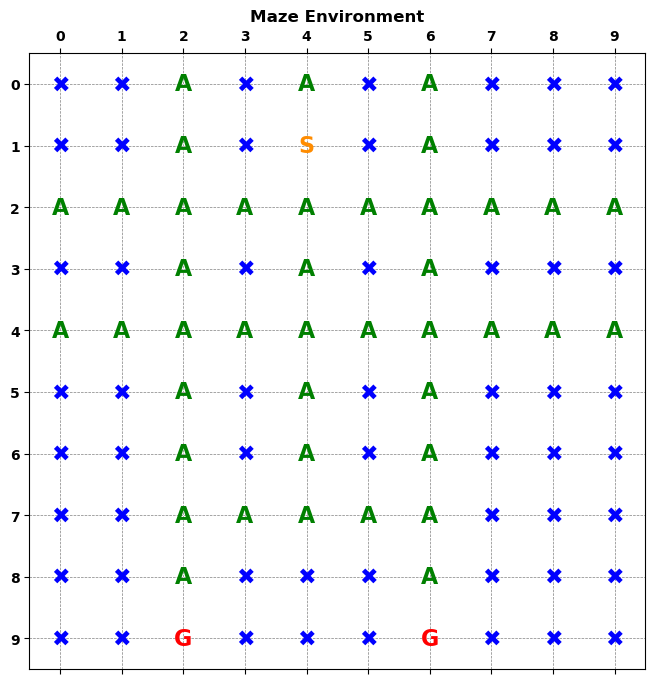

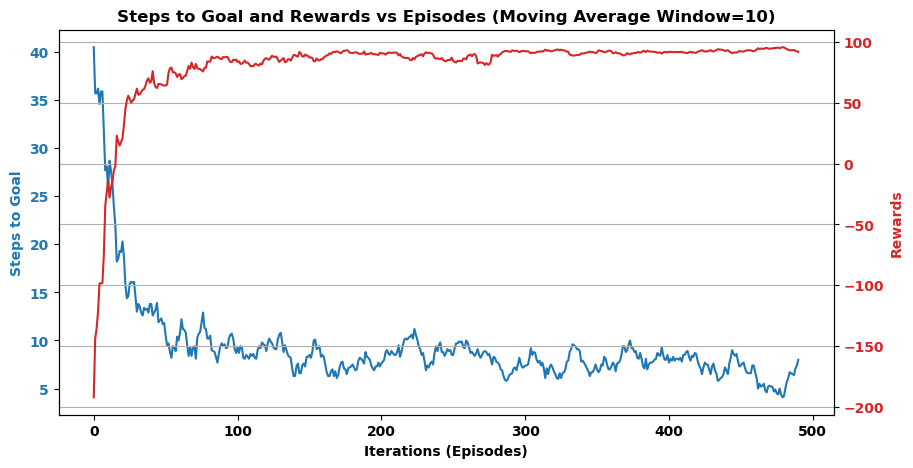

In [5]:
# Define Q-Learning Parameters
num_iters = 500
alpha = 0.7
gamma = 0.7
epsilon = 0.5
max_steps = 50
fast_delivery_limit = FAST_DELIVERY_LIMIT
fast_delivery = FAST_DELIVERY
slow_delivery = SLOW_DELIVERY

# Visualize the Maze Environment with the actual starting position
starting_position = env.reset()
plot_maze(env, starting_position)

# Execute Q-Learning with Default Gamma
    #Q_hat is an estimation from the true Qvalue
q_hat, steps_vs_iters, rewards_vs_iters = qlearn(env,        
                                                 num_iters,
                                                 alpha,
                                                 gamma, 
                                                 epsilon,
                                                 max_steps,
                                                 fast_delivery_limit, 
                                                 fast_delivery,
                                                 slow_delivery)

# Plot Steps and Rewards with Moving Average
plot_steps_vs_iters(steps_vs_iters, rewards_vs_iters, window=10)

Comments about the results:

a) Stepts to goal/iterations.... I did some experiments and it is important to give th eagent time /iterations sufficient to learn the best policy. During one of the training the blue line went to the bottom but then went up again... this probably was because the agent found a new policy and overused it



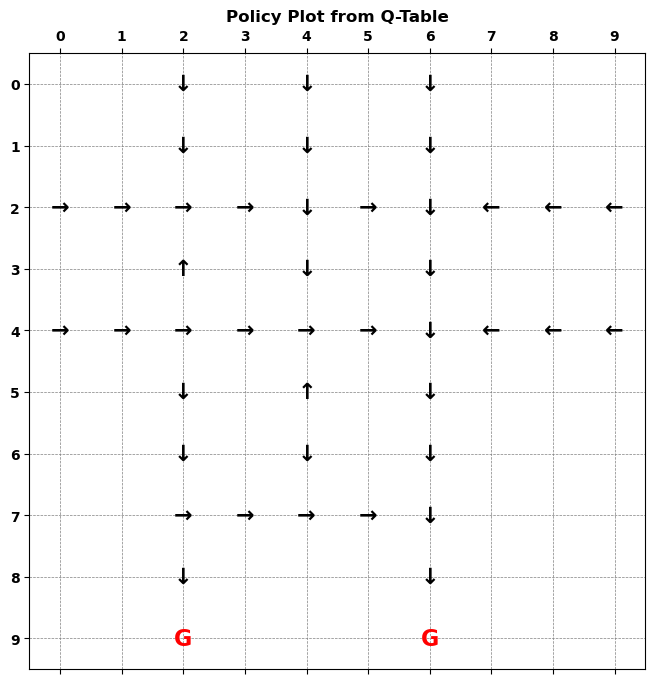

In [6]:

# Plot Policy from Q Table
plot_policy_from_q(q_hat, env)

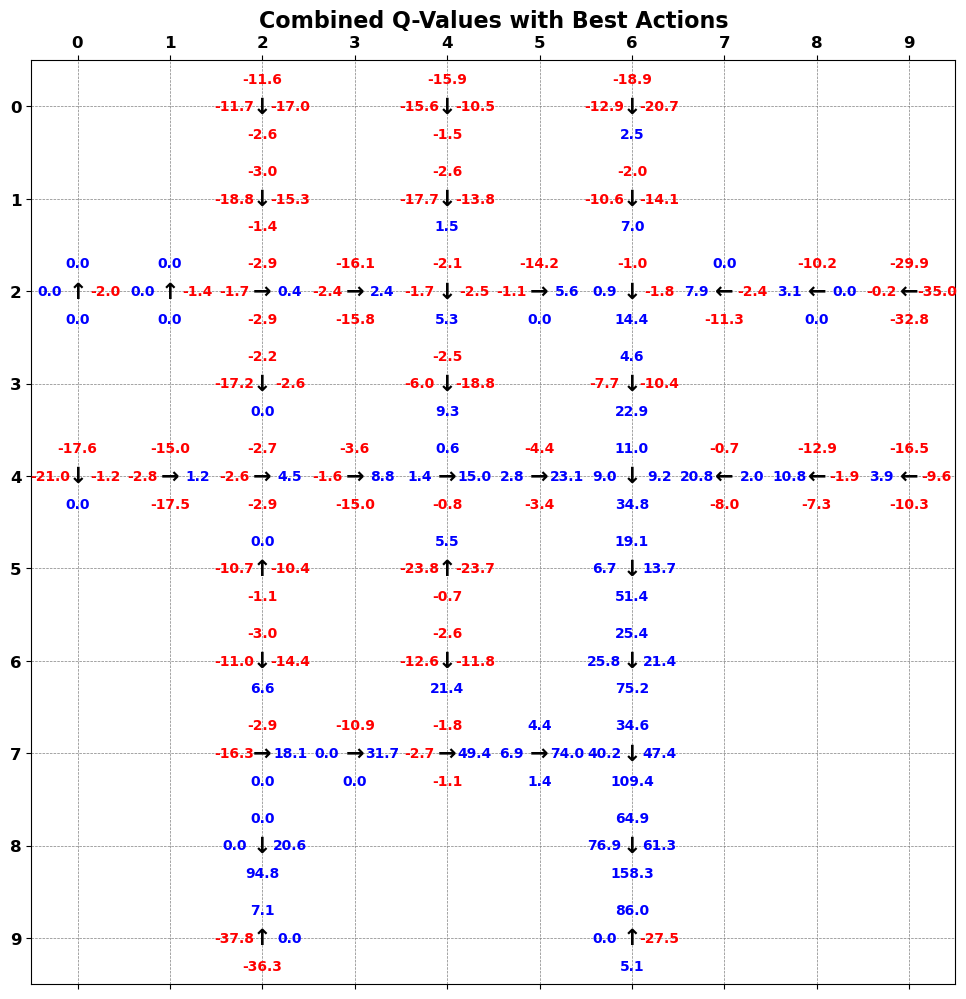

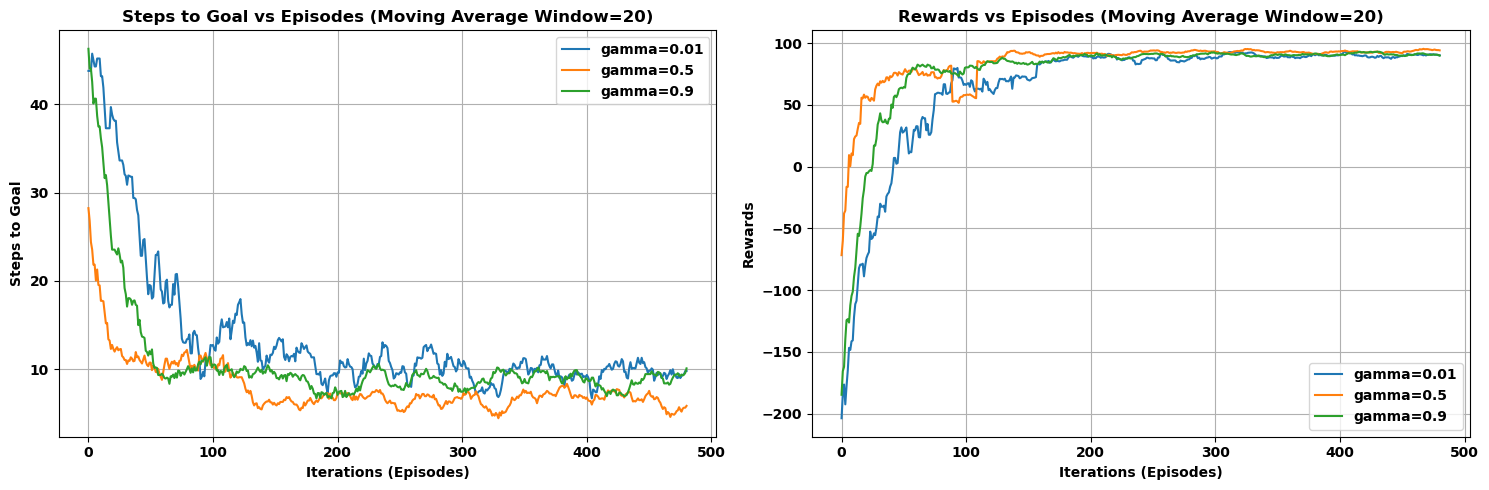

In [11]:
# Visualize Q-Matrix with Colored Arrows
plot_q_values_with_colored_arrows(q_hat, env)

# Experiment with Different Gamma Values
gamma_list = [0.01, 0.5, 0.9]
steps_vs_iters_list_gamma = []
rewards_vs_iters_list_gamma = []

for gamma_val in gamma_list:
    _, steps_vs_iters_gamma, rewards_vs_iters_gamma = qlearn(env, 
                                                             num_iters, 
                                                             alpha, 
                                                             gamma_val,
                                                             epsilon, 
                                                             max_steps,
                                                             fast_delivery_limit,
                                                             fast_delivery, 
                                                             slow_delivery)
    steps_vs_iters_list_gamma.append(steps_vs_iters_gamma)
    rewards_vs_iters_list_gamma.append(rewards_vs_iters_gamma)

# Plot Results for Different Gamma Values
label_list_gamma = [f'gamma={gamma}' for gamma in gamma_list]
plot_several_steps_vs_iters(steps_vs_iters_list_gamma, 
                            rewards_vs_iters_list_gamma,
                            label_list_gamma, 
                            window=20)

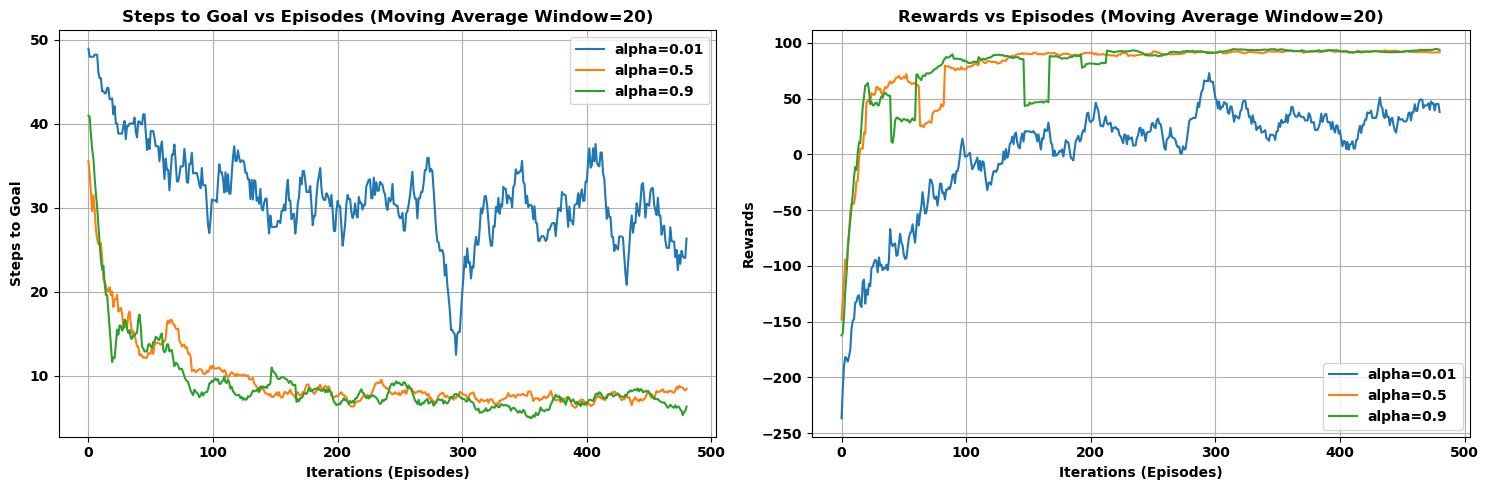

In [10]:
# Experiment with Different Alpha Values
alpha_list = [0.01, 0.5, 0.9]
steps_vs_iters_list_alpha = []
rewards_vs_iters_list_alpha = []

for alpha_val in alpha_list:
    _, steps_vs_iters_alpha, rewards_vs_iters_alpha = qlearn(env, 
                                                             num_iters,
                                                             alpha_val,
                                                             gamma, 
                                                             epsilon, 
                                                             max_steps,
                                                             fast_delivery_limit,
                                                             fast_delivery, 
                                                             slow_delivery)
    steps_vs_iters_list_alpha.append(steps_vs_iters_alpha)
    rewards_vs_iters_list_alpha.append(rewards_vs_iters_alpha)

# Plot Results for Different Alpha Values
label_list_alpha = [f'alpha={alpha}' for alpha in alpha_list]
plot_several_steps_vs_iters(steps_vs_iters_list_alpha, 
                            rewards_vs_iters_list_alpha,
                            label_list_alpha,
                            window=20)

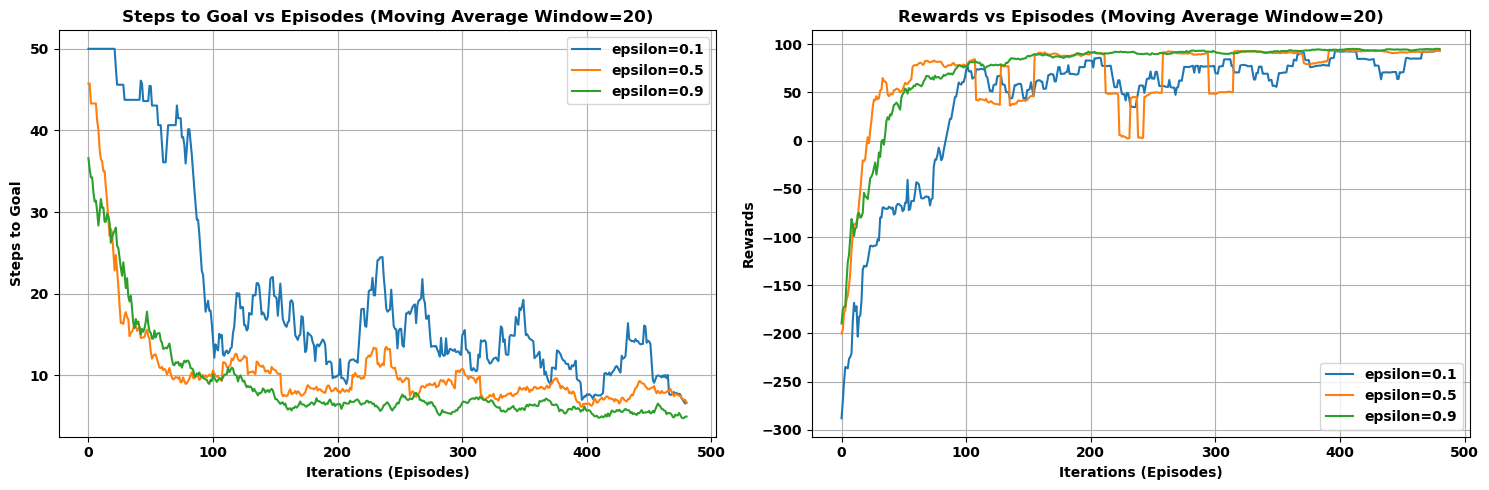

In [9]:
# Experiment with Different Epsilon Values
epsilon_list = [0.1, 0.5, 0.9]  # Define a list of epsilon values to test
steps_vs_iters_list_epsilon = []
rewards_vs_iters_list_epsilon = []

for epsilon_val in epsilon_list:
    # Run Q-learning with each epsilon value while keeping other parameters constant
    _, steps_vs_iters_epsilon, rewards_vs_iters_epsilon = qlearn(env, 
                                                                 num_iters,
                                                                 alpha,
                                                                 gamma, 
                                                                 epsilon_val,  # Use variable epsilon value here
                                                                 max_steps,
                                                                 fast_delivery_limit,
                                                                 fast_delivery, 
                                                                 slow_delivery)
    # Collect results for each epsilon scenario
    steps_vs_iters_list_epsilon.append(steps_vs_iters_epsilon)
    rewards_vs_iters_list_epsilon.append(rewards_vs_iters_epsilon)

# Plot Results for Different Epsilon Values
label_list_epsilon = [f'epsilon={epsilon}' for epsilon in epsilon_list]  # Labels for the plots
plot_several_steps_vs_iters(steps_vs_iters_list_epsilon, 
                            rewards_vs_iters_list_epsilon,
                            label_list_epsilon,
                            window=20)  # Moving average window for smoothing the plot
